# Brief description of the problem and data

The problem is to identify metastatic cancer in small image patches taken from larger digital pathology scans. To achieve this, a training set containing each image labeled as positive whenever the center 32x32px region of a patch contains at least one pixel of tumor tissue.

- Objective: The score is evaluated as area under the ROC curve between predicted and observed values. Various convnets model structures will be examined to determine the best performing architecture for this problem.

- Type of Problem: Binary image classification.

- Dataset: Modified version of the PatchCamelyon (PCam) benchmark dataset.

Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection

In [15]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

In [3]:
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [4]:
train_data.info()
print("\n")
print("Count of test observations:",len(os.listdir(test_path)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Count of test observations: 57458


# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data



In a quick note, this is how the image will look on very low resolution (10x10). For the example 10x10 is chosen so the values can be observed easily in matrix form. For modeling a 64x64 is used instead.

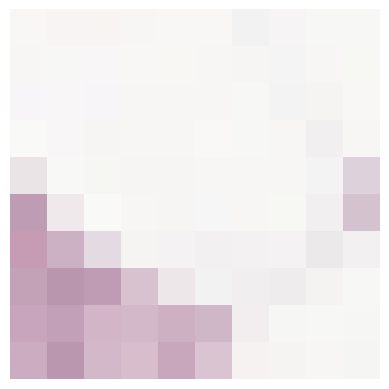

In [5]:
# Locate a single image
image_path = os.path.join(train_path, train_data['id'][0] + '.tif')  
image = Image.open(image_path)

# Resize the image
image = image.resize((10, 10))

# Convert the image to a numpy array
image_matrix = np.array(image)
plt.imshow(image_matrix)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

And this is how the low resolution image is represented in a (10x10x3) matrix.

In [6]:
# Print formatted matrix
print(image_matrix.shape, "\n")
for row in range(image_matrix.shape[0]):
    for col in range(image_matrix.shape[1]):
        # Print each RGB value formatted to be always three digits
        print(f'[{image_matrix[row, col][0]:03},{image_matrix[row, col][1]:03},{image_matrix[row, col][2]:03}]', end=' ')
    print()  # Newline for each new row

(10, 10, 3) 

[248,247,245] [247,244,243] [247,244,242] [247,246,244] [248,247,245] [248,247,245] [243,242,242] [246,244,245] [247,247,246] [247,247,245] 
[247,246,245] [247,247,245] [248,246,246] [248,247,245] [248,247,244] [247,246,244] [246,245,243] [245,244,245] [247,246,245] [247,247,244] 
[247,245,247] [248,246,247] [247,245,247] [247,246,245] [247,246,244] [247,246,244] [247,247,245] [244,243,244] [245,244,243] [248,247,245] 
[249,249,248] [248,246,247] [247,245,244] [247,246,244] [247,246,244] [249,248,246] [247,247,245] [247,246,245] [241,239,239] [247,246,245] 
[234,228,231] [248,248,247] [246,246,243] [246,245,243] [246,245,243] [247,246,244] [247,246,244] [247,246,244] [244,243,243] [221,210,219] 
[190,157,180] [240,233,236] [249,250,248] [247,246,244] [246,245,243] [247,246,246] [247,246,245] [247,247,244] [241,239,239] [212,195,207] 
[197,156,180] [204,176,195] [228,218,225] [245,244,243] [244,242,242] [243,240,241] [243,241,242] [244,242,242] [236,233,235] [243,240,241] 

A 64x64 resolution is shown below, comparing tumor vs. non-tumor cases.

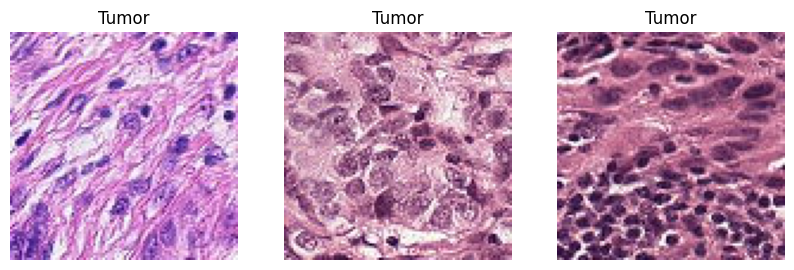

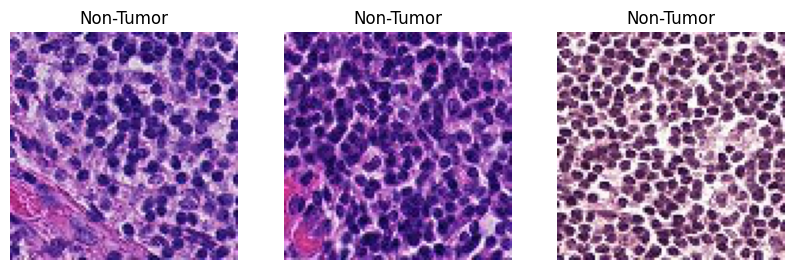

In [7]:
sample_tumor_ids = train_data[train_data['label'] == 1]['id'].sample(n=3).values
sample_normal_ids = train_data[train_data['label'] == 0]['id'].sample(n=3).values

tumor_images = []
for id in sample_tumor_ids:
    image_path = os.path.join(train_path, id + '.tif')  
    tumor_images.append(Image.open(image_path))
    
normal_images = []
for id in sample_normal_ids:
    image_path = os.path.join(train_path, id + '.tif') 
    normal_images.append(Image.open(image_path))
    
plt.figure(figsize=(10, 3))
for i, image in enumerate(tumor_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Tumor')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 3))
for i, image in enumerate(normal_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Non-Tumor')
    plt.axis('off')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


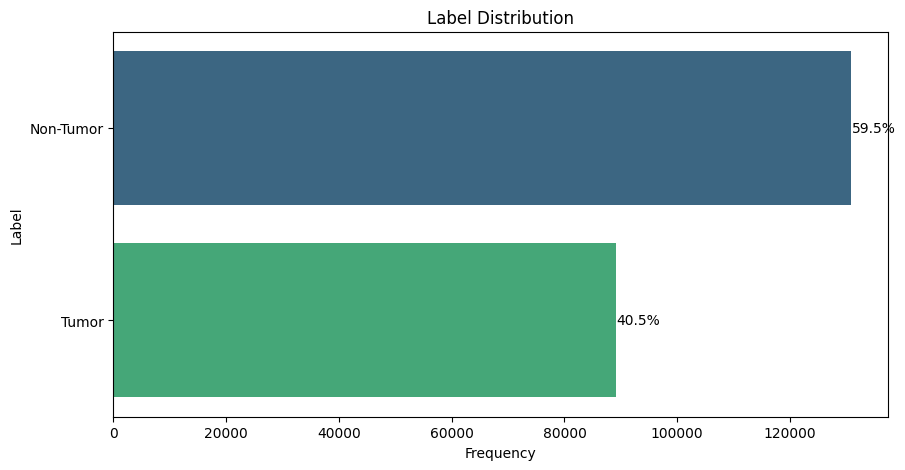

In [8]:
counts = train_data['label'].value_counts().reset_index()
counts.columns = ['Label', 'Frequency']
counts['Label'] = counts['Label'].map({0:'Non-Tumor', 1:'Tumor'})
counts['Percentage'] = (counts['Frequency'] / counts['Frequency'].sum()) * 100
plt.figure(figsize=(10, 5))
bar_plot = sns.barplot(data=counts, x='Frequency', y='Label', palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Frequency')
plt.ylabel('Label')
for index, row in counts.iterrows():
    bar_plot.text(row['Frequency'], index, f"{row['Percentage']:.1f}%", va='center')

plt.show()

Apply some data transformations to fit into tf model expected input.

In [9]:
train_data["id"] = train_data["id"] + ".tif"
train_data["label"] = train_data["label"].astype(str)
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


The rgb values are scaled to 0-1 by dividing by 255, then the train data is split into 80% training and 20% validation. A 256 batch size is chosen optimizing for lower runtime and will be tweaked later based on performance.

In [10]:
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2)
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=256,
    seed=28,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 176020 validated image filenames belonging to 2 classes.


In [11]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=256,
    seed=28,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 44005 validated image filenames belonging to 2 classes.


**Plan of Analysis**

- Model Building Plan
    - Baseline Model (Model 1): The architecture will include sequential layers of Conv2D, pooling, and dense layers, ending with a sigmoid output for binary classification. This model serves as a benchmark to evaluate the effectiveness of more complex architectures and additional techniques used in the enhanced model.

    - Enhanced Model (Model 2): Incorporates advanced techniques like dropout for regularization, batch normalization for faster and stable training, and Adam optimizer with a specific learning rate for efficient learning. These enhancements are expected to improve the model's ability to generalize and perform better on unseen data.
    
- Subsequent Analysis Plan
    - Evaluate both models using accuracy, loss, and ROC-AUC. Accuracy provides a straightforward metric of performance, loss offers insight into the model’s learning process, and ROC-AUC is particularly useful for binary classification tasks in this slightly imbalanced dataset.

# Model Architecture

**Model 1: Baseline Model**
This will be a baseline CNN model with basic architecture:
- Architecture: Input → Conv2D (filter=16) → Conv2D (filter=16) → MaxPool → Conv2D (filter=32) → Conv2D (filter=32) → AveragePool → Flatten → Dense → Output (Sigmoid)
- Normalization: Pre-training normalization of images by dividing pixel values by 255.
- Output Layer Activation: Sigmoid, suitable for binary classification.
- Batch Size: 256 as explained above.
- Image Target Size: 64x64 (original 96x96). Explained above.
- Epochs: 5 epochs for training to reduce training time while standardising across both models.
- Loss Function: Binary cross-entropy.
- Performance Metrics: Accuracy and ROC-AUC curve.

**Model 2: Enhanced Model**
This model includes several enhancements for better performance and generalization:

- All features of Model 1
- Dropout: Set at 0.1 to reduce overfitting by randomly setting a fraction of input units to 0 at each update during training.
- Batch Normalization: Helps in stabilizing and speeding up the training.
- Optimizer: Adam with a learning rate of 0.001. Adam is efficient, and a smaller learning rate ensures more precise updates, reducing the chance of overshooting the minimum.
- Hidden Layer Activations: ReLU (Rectified Linear Unit), which helps with faster convergence and reduces the likelihood of vanishing gradients.
- Additional Hyperparameters Tuning: In addition, after reviewing model 1, we will experiment with some changes to hyperparamters to improve on model 1 (e.g. filters, kernel size, no. of convo layers). 

The key difference between the two models lies in the addition of Batch Normalization, Dropout, and ReLU activation in Model 2, making it more sophisticated and potentially more capable of handling overfitting than Model 1 and in identnfying cancerous tissues for the problem.

- Dropout for Regularization: Dropout at a rate of 0.1 helps prevent overfitting by randomly deactivating certain neurons, encouraging the model to learn generalized features rather than overly relying on specific training data aspects. This is crucial for medical imaging, where models must perform well on unseen data.

- Batch Normalization for Stability: Batch normalization stabilizes the training by normalizing layer inputs, maintaining a consistent distribution throughout training. This stability is vital in medical image analysis for achieving reliable and precise models.

- ReLU Activation for Complexity: ReLU activation introduces necessary non-linearity, enabling the model to capture complex patterns in medical images. It also mitigates the vanishing gradient problem, facilitating the training of deeper networks.

- Adam Optimizer for Efficiency: Adam optimizer, efficient in sparse gradient handling and adaptive in learning rate adjustment, suits medical image analysis well. It ensures precise and optimal updates during training, crucial for capturing fine details in medical diagnostics.

**Note: 5 epochs will be standardised across all models due to the GPU limit.**

Additional Resources:
- https://www.baeldung.com/cs/ml-relu-dropout-layers
- https://www.linkedin.com/pulse/ways-improve-your-deep-learning-model-batch-adam-albuquerque-lima/

# Results and Analysis

With the architecture laid out, we will proceed to train our model using ROC as the metrics. 

In [12]:
model1_ROC = tf.keras.metrics.AUC()

model1 = Sequential()
    
model1.add(Conv2D(filters=16, kernel_size=(3,3)))
model1.add(Conv2D(filters=16, kernel_size=(3,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3)))
model1.add(Conv2D(filters=32, kernel_size=(3,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))
    
model1.build(input_shape=(32, 64, 64, 3))
    
model1.compile(loss='binary_crossentropy', metrics=['accuracy', model1_ROC])
    
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 62, 62, 16)          448       
                                                                 
 conv2d_1 (Conv2D)           (32, 60, 60, 16)          2320      
                                                                 
 max_pooling2d (MaxPooling2  (32, 30, 30, 16)          0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (32, 28, 28, 32)          4640      
                                                                 
 conv2d_3 (Conv2D)           (32, 26, 26, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 13, 13, 32)          0         
 g2D)                                                   

In [13]:
his_model1 = model1.fit(
                        train_generator,
                        steps_per_epoch=687,
                        epochs = 5,
                        validation_data = valid_generator,
                        validation_steps=171,
                        verbose=1)

Epoch 1/5
687/687 [==============================] - 1449s 2s/step - loss: 0.5900 - accuracy: 0.6945 - auc: 0.7423 - val_loss: 0.6145 - val_accuracy: 0.6790 - val_auc: 0.8378
Epoch 2/5
687/687 [==============================] - 402s 586ms/step - loss: 0.4999 - accuracy: 0.7663 - auc: 0.8296 - val_loss: 0.5272 - val_accuracy: 0.7388 - val_auc: 0.8582
Epoch 3/5
687/687 [==============================] - 331s 481ms/step - loss: 0.4771 - accuracy: 0.7822 - auc: 0.8466 - val_loss: 0.4725 - val_accuracy: 0.7826 - val_auc: 0.8621
Epoch 4/5
687/687 [==============================] - 347s 505ms/step - loss: 0.4631 - accuracy: 0.7892 - auc: 0.8565 - val_loss: 0.5140 - val_accuracy: 0.7643 - val_auc: 0.8569
Epoch 5/5
687/687 [==============================] - 389s 567ms/step - loss: 0.4525 - accuracy: 0.7950 - auc: 0.8635 - val_loss: 0.4675 - val_accuracy: 0.7888 - val_auc: 0.8697


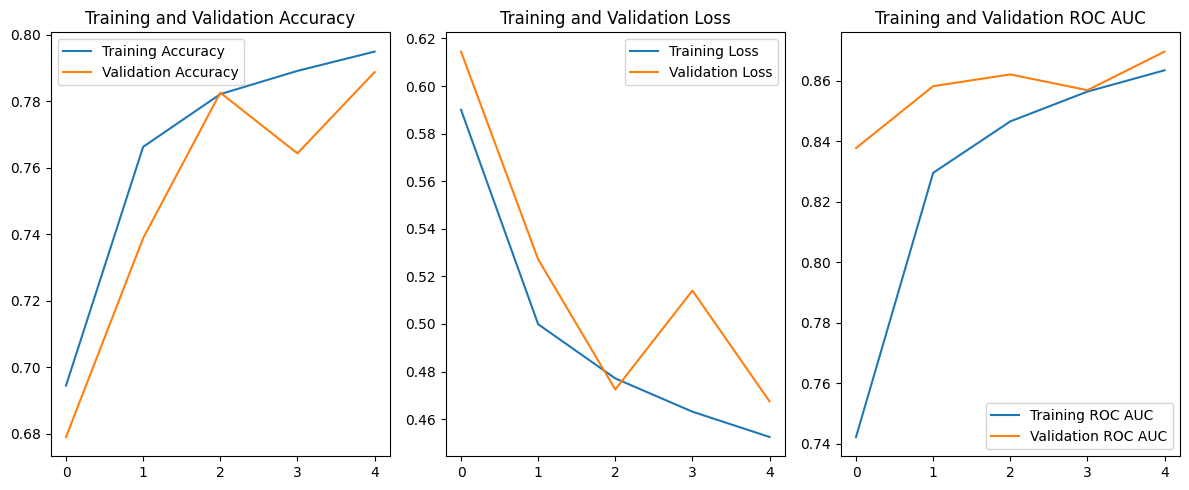

In [14]:
acc = his_model1.history['accuracy']
val_acc = his_model1.history['val_accuracy']
loss = his_model1.history['loss']
val_loss = his_model1.history['val_loss']
roc_auc = his_model1.history['auc']
val_roc_auc = his_model1.history['val_auc']

epochs = range(len(acc))

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# ROC AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, roc_auc, label='Training ROC AUC')
plt.plot(epochs, val_roc_auc, label='Validation ROC AUC')
plt.title('Training and Validation ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()


**Model 1 Results**

Training and Validation Accuracy:

The training accuracy improved over the 5 epochs, which indicates that the model is learning and improving its performance on the training data.
The validation accuracy also increased in Epoch 4, before dropping slightly in the final epoch. This suggests the model is generalizing to unseen data, though the drop in the last epoch could be a sign of beginning overfitting or variability in the validation dataset.

Training and Validation Loss:

The training loss decreased consistently, showing that the model is getting better at classifying the training images.
The validation loss decreased until Epoch 4, indicating improving validation performance. However, the increase in validation loss in the final epoch could suggest that the model started to overfit the training data or that there's a variation in the difficulty of the validation set.

Training and Validation ROC AUC:

The ROC AUC for the training set improved, which is a good sign that the model is increasingly able to distinguish between the positive and negative classes.
The validation ROC AUC followed a similar upward trend, peaking at Epoch 4 before a slight decrease in Epoch 5. The high ROC AUC values suggest that the model has a good measure of separability and is able to rank the positive class higher than the negative class with high confidence.

Overall Interpretation:
Model 1 is performing reasonably well on this binary classification task. The metrics show that it is learning as expected, and there is a general improvement in its ability to classify the images correctly. However, the slight decrease in validation accuracy and ROC AUC in the final epoch alongside an increase in validation loss indicates that the model may be starting to overfit the training data, as it's getting more specialized in the training set at the expense of generalization. This is a common phenomenon when the model learns patterns that are too specific to the training data, which don't generalize well to new, unseen data. 

Clearly, with a baseline model, we can see that the performance using CNN is already reasonably well. We will now look at the improvement in architecture for model 2.

# Model 2

In [23]:
model2_ROC = tf.keras.metrics.AUC()

model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(3,3)))
model2.add(Activation("relu"))
model2.add(Conv2D(filters=16, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(filters=32, kernel_size=(3,3)))
model2.add(Activation("relu"))
model2.add(Conv2D(filters=32, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dense(1, activation = "sigmoid"))

model2.build(input_shape=(32, 64, 64, 3))

model2.compile(SGD(learning_rate = 0.01), loss = "binary_crossentropy", metrics=['accuracy', model2_ROC])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (32, 62, 62, 16)          448       
                                                                 
 activation_4 (Activation)   (32, 62, 62, 16)          0         
                                                                 
 conv2d_9 (Conv2D)           (32, 60, 60, 16)          2320      
                                                                 
 batch_normalization_2 (Bat  (32, 60, 60, 16)          64        
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (32, 60, 60, 16)          0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 30, 30, 16)          0         
 g2D)                                                 

In [24]:
his_model2 = model2.fit(
                        train_generator, 
                        steps_per_epoch=687, 
                        epochs=5,
                        validation_data=valid_generator,
                        validation_steps=171,
                        verbose=1)

Epoch 1/5


2024-06-06 03:44:50.231065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


687/687 [==============================] - 340s 493ms/step - loss: 0.6106 - accuracy: 0.7604 - auc_2: 0.8145 - val_loss: 0.9251 - val_accuracy: 0.6301 - val_auc_2: 0.7849
Epoch 2/5
 51/687 [=>............................] - ETA: 3:55 - loss: 0.4744 - accuracy: 0.7932 - auc_2: 0.8566

KeyboardInterrupt: 

In [21]:
print(his_model2.history.keys())

dict_keys(['loss', 'accuracy', 'auc_1', 'val_loss', 'val_accuracy', 'val_auc_1'])


In [20]:
his_model2

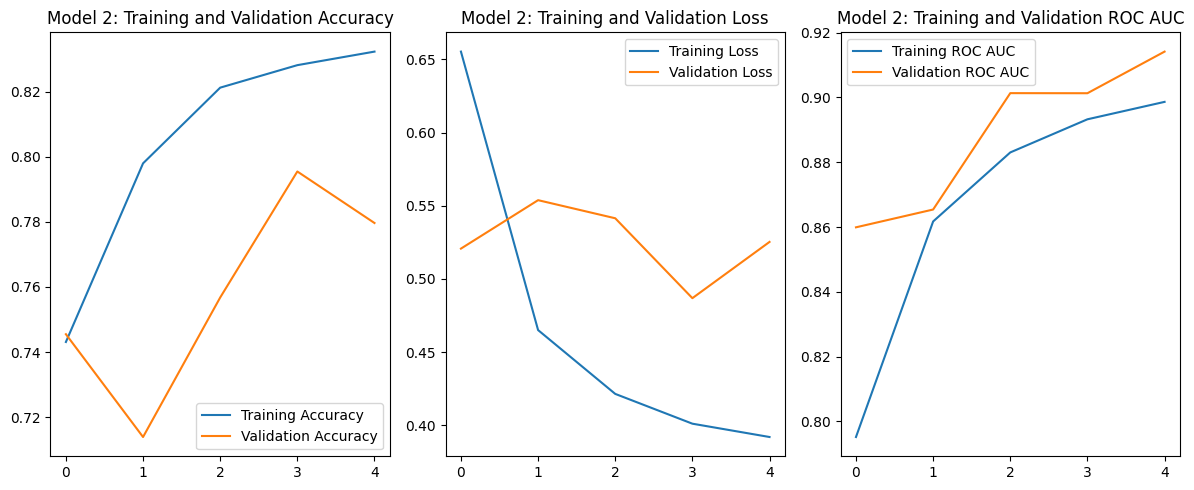

In [22]:
acc2 = his_model2.history['accuracy']
val_acc2 = his_model2.history['val_accuracy']
loss2 = his_model2.history['loss']
val_loss2 = his_model2.history['val_loss']
roc_auc2 = his_model2.history['auc_1']
val_roc_auc2 = his_model2.history['val_auc_1']

epochs = range(len(acc))

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc2, label='Training Accuracy')
plt.plot(epochs, val_acc2, label='Validation Accuracy')
plt.title('Model 2: Training and Validation Accuracy')
plt.legend()

# loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss2, label='Training Loss')
plt.plot(epochs, val_loss2, label='Validation Loss')
plt.title('Model 2: Training and Validation Loss')
plt.legend()

# ROC AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, roc_auc2, label='Training ROC AUC')
plt.plot(epochs, val_roc_auc2, label='Validation ROC AUC')
plt.title('Model 2: Training and Validation ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Test Results

In [ ]:
test_data = pd.DataFrame({'id':os.listdir(test_path)})
test_data.head()

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),
    batch_size=1,
    shuffle=False,
    class_mode=None)

In [ ]:
results = model2.predict(test_generator, verbose=1)

In [ ]:
results = np.transpose(results)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, results))
submission_df.head()

In [ ]:
submission_df.to_csv('submission.csv', index=False)